# Identifying the modified part from an Image

# IFS-TC Forensics Challenge

## [1.0] Business Problem
- The IEEE Information Forensics Security Technical Committee (IFS-TC) launched a detection and localization forensics challenge, the first Image Forensics Challenge.
- In the last years, the field of Digital Image Forensics has emerged with several tools and algorithms presented to help researchers and forensic experts to interpret the authenticity of digital documents.
- However, the lack of a clear benchmark and common comparison protocol of such algorithms has limited us to gauge them under real-world conditions

## [1.1] Problem Statement
- Given an input image our task is to predict the modified part in an image, or to identify forgeries in digital images.
- To evaluate the current state-of-the-art techniques with respect to their ability to detect image forgeries (content manipulation)
- This is the task of identifying content manipulation

## [1.2] References
- https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
- https://www.immersivelimit.com/tutorials/mask-rcnn-for-windows-10-tensorflow-2-cuda-101
- https://www.pyimagesearch.com/2019/06/10/keras-mask-r-cnn/
- https://www.kaggle.com/c/tgs-salt-identification-challenge
- http://web.archive.org/web/20171014064017/http://ifc.recod.ic.unicamp.br/fc.website/index.py?sec=1
- https://www.jeremyjordan.me/semantic-segmentation/
- https://arxiv.org/pdf/1505.04597.pdf

## [2.0] Data Overview
- We have folder of fake images of total 900 digital images out of which 450 are digital images and rest 450 are their corresponding masks.
- In an input image we have to identify the modified part for these 450 images

## [2.1] Performance Metric
- Jaccard Similarity: It is one of the performance metric which we will be using. It is also known as Intersection over Union (IoU).
- 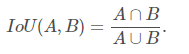
- Here A is our ground truth and B is our model predicted output.
- We compute this value at each pixel and then take an average precision.
- For that we keep a thresholding values which ranges from 0.5 - 0.95. It is a hyperparameter to tune.
- At each threshold value t, a precision value is calculated based on the number of TP(true positives), false negatives(FN) and false positives(FP) resulting from comparing the predicted object to all ground truth objects.
- A TP is counted when a single predicted object matches a ground truth object with IoU above the threshold.
- A FP indicates a predicted object has no associated ground truth.
- A FN indicates a ground truth object has no associated preicted object.
- The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold

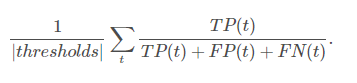

## [3.0] Data Preprocessing

In [1]:
!pip install segmentation-models

  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [2]:
!pip install maskrcnn

In [3]:
!pip install mrcnn

In [2]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
#tf.enable_eager_execution()
tf.executing_eagerly() 

True

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1035505435567105840
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5990915633557985407
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8801061149005264070
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices:
#    tf.config.experimental.set_memory_growth(device, True)
#print(device)

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [8]:
#!git clone https://github.com/tomgross/Mask_RCNN.git --branch tensorflow-2.0

In [9]:
#!cd Mask_RCNN

In [10]:
#!pip install --upgrade pip
#!pip install -r requirements.txt
#!pip install -e .

In [11]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Add
from tensorflow import concat
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

## [3.1] Loading modified and masks images into two different folders

In [14]:
import os

# path to image folder, get all filenames on this folder
# and store it in the onlyfiles list

if os.path.exists('lis1'):
    
    mypath = "fake"
    onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

    # your list of masks
    lis1 = ["mask.png"]

    # create two seperate lists from onlyfiles list based on lis1 and lis2
    lis1files = [i for i in onlyfiles for j in lis1 if j in i]
    lis2files = [i for i in onlyfiles for j in lis1 if not j in i]

    # create two sub folders in mypath folder
    subfolder1 = os.path.join(mypath, "lis1")
    subfolder2 = os.path.join(mypath, "lis2")

    # check if they already exits to prevent error
    if not os.path.exists(subfolder1):
        os.makedirs(subfolder1)

    if not os.path.exists(subfolder2):
        os.makedirs(subfolder2)

    # move files to their respective sub folders
    for i in lis1files:
        source = os.path.join(mypath, i)
        destination = os.path.join(subfolder1, i)
        os.rename(source, destination)

    for i in lis2files:
        source = os.path.join(mypath, i)
        destination = os.path.join(subfolder2, i)
        os.rename(source, destination)
else:
    print('The directories are existing')

The directories are existing


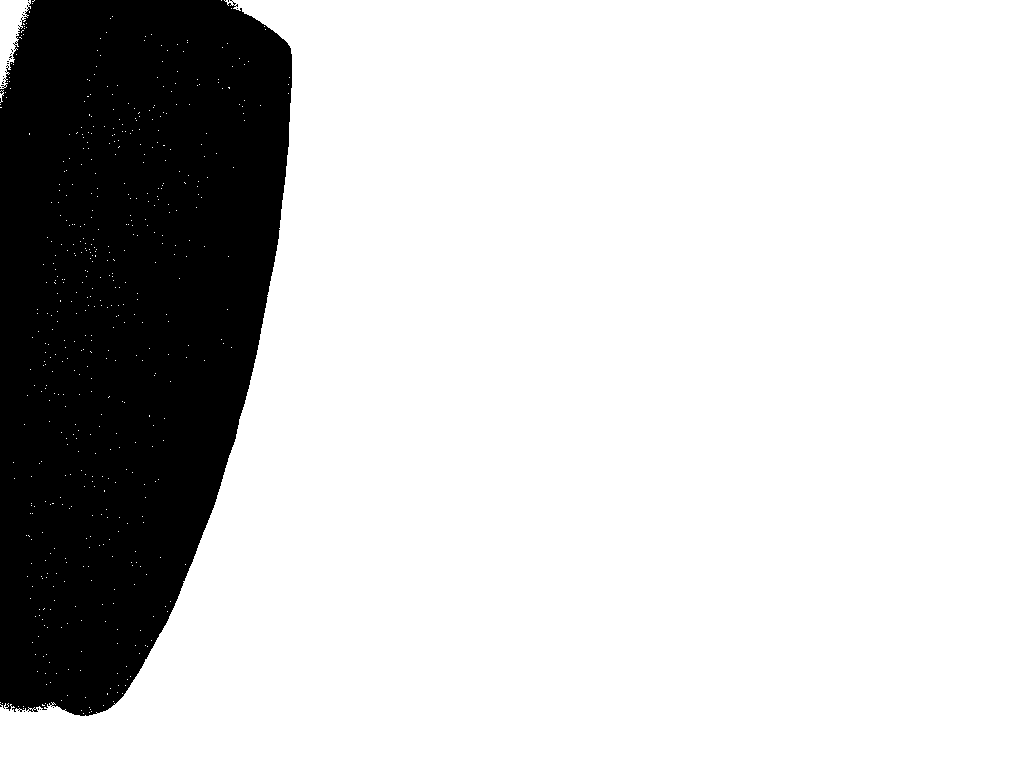

In [15]:
from tensorflow.keras.preprocessing.image import load_img

img = load_img('fake/lis1/b16b83b24a10d28f3d89eca9e505f294.mask.png')
img

In [16]:
img_ = img_to_array(img)
img_.shape

(768, 1024, 3)

In [17]:
res = resize(img_, (128, 128, 1), mode = 'constant', preserve_range = True)


In [12]:
ids_mask = next(os.walk("fake/lis1"))[2]
print('Ids of mask: ',len(ids_mask))
ids_only = next(os.walk("fake/lis2"))[2]
print('Ids only: ',len(ids_only))

Ids of mask:  450
Ids only:  450


In [13]:
im_height = 256
im_width = 256
channels = 1
X = np.zeros((len(ids_only), im_height, im_width, channels), dtype=np.float32)
y = np.zeros((len(ids_mask), im_height, im_width, channels), dtype=np.float32)

In [14]:
X.shape

(450, 256, 256, 1)

## [3.2] Loading images numpy arrays

In [15]:
tf.keras.backend.clear_session()

In [16]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True )

In [17]:
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [18]:
#model = VGG16(input_shape = X.shape[1:], include_top = False, weights = 'imagenet')
#model.trainable = False
#model.summary()

In [19]:
#model = VGG16()

In [20]:
#import tqdm
#directory = "fake/lis2"
#model.layers.pop()
#model = Model(inputs = model.inputs, outputs = model.layers[-6].output)

#for n,i in tqdm.tqdm_notebook(enumerate(os.listdir(directory))):
 #   img = load_img(directory + '/' + i, target_size = (224,224))
 #   x_img = img_to_array(img)
   # print(x_img.shape)
 #   x_img = x_img.reshape((1,x_img.shape[0], x_img.shape[1], x_img.shape[2]))
   # print(x_img.shape)
    
 #   image = preprocess_input(x_img)
   # print(image.shape)
    
  #  feature = model.predict(image ,verbose = 0)
   # print(feature.shape)
   # feat_reshape = feature.reshape((256,-1,1))
    #print(feat_reshape.shape)
    #break
    
  #  X[n] = feat_reshape
    #break

In [21]:
#model.layers[-3].output

In [22]:
import tqdm
directory = "fake/lis2"
for n,i in tqdm.tqdm_notebook(enumerate(os.listdir(directory))):
    img = load_img(directory + '/' + i)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, channels), mode = 'constant', preserve_range = True)
    X[n] = x_img/255.0

In [23]:
directory1 = "fake/lis1"
directory2 = "fake/lis2"

mask_ids = []
for i in os.listdir(directory1):
    #print(i)
    mask_ids.append(i)

image_ids = []
for j in os.listdir(directory2):
    #print(j)
    image_ids.append(j)


images = []
masks = []

for k in image_ids:
    img,l = k.split('.')
    images.append(img)
    #print(images)
#print(images)  

for m in mask_ids:
    msk,l = m.split('.mask')
    masks.append(msk)
#print(masks)



if images == masks:
    print('The lists are identical')
else:
    print('The lists are not identical')

The lists are identical


In [24]:
#import tqdm
#import warnings
#warnings.filterwarnings('ignore')
# tqdm is used to display the progress bar
#for n, id_ in tqdm.tqdm_notebook(enumerate(ids_only), total=len(ids_only)):
#    img = load_img("fake/lis2/"+id_)
#    x_img = img_to_array(img)
#    x_img = resize(x_img, (im_height, im_width, channels), mode = 'constant', preserve_range = True)
#    X[n] = x_img/255.0

## [3.3] Loading masks into numpy arrays

In [25]:
#model = VGG16()

In [26]:
#import tqdm
#directory = "fake/lis1"
#model.layers.pop()
#model = Model(inputs = model.inputs, outputs = model.layers[-6].output)

#for n,i in tqdm.tqdm_notebook(enumerate(os.listdir(directory))):
#    img = load_img(directory + '/' + i, target_size = (224,224))
#    mask = img_to_array(img)
#    #print(x_img.shape)
#    mask = mask.reshape((1,mask.shape[0], mask.shape[1], mask.shape[2]))
#    #print(x_img.shape)
    
 #   image = preprocess_input(mask)
    #print(image.shape)
    
#    feature = model.predict(image ,verbose = 0)
    #print(feature.shape)
#    feat_reshape = feature.reshape((256,-1,1))
    #print(feat_reshape.shape)
    #break
    
    #y[n] = feat_reshape
    
#    y[n] = np.where(feat_reshape > 127,1,0)
    #break

In [27]:
import tqdm
directory = "fake/lis1"
for n,i in tqdm.tqdm_notebook(enumerate(os.listdir(directory))):
    #img = load_img(directory + '/' + i)
    mask = img_to_array(load_img("fake/lis1/"+i))
    mask = resize(mask, (im_height, im_width, channels), mode = 'constant', preserve_range = True)
    # Save images
    y[n] = np.where(mask > 127,1,0)

In [28]:
#import tqdm
#for n, id_ in tqdm.tqdm_notebook(enumerate(ids_mask), total=len(ids_mask)):
#    mask = img_to_array(load_img("fake/lis1/"+id_))
#    mask = resize(mask, (im_height, im_width, channels), mode = 'constant', preserve_range = True)
#    # Save images
#    y[n] = np.where(mask > 127,1,0)

## [3.4] Splitting data into train and validation

In [29]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

In [36]:
X_valid[9].shape

(256, 256, 1)

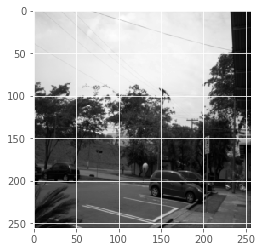

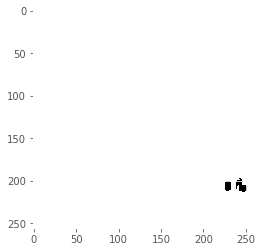

In [37]:
plt.imshow(X_train[15].squeeze(),cmap = 'gray')
plt.show()
plt.imshow(y_train[15].squeeze(), cmap = 'gray')

Text(0.5, 1.0, 'Mask Image')

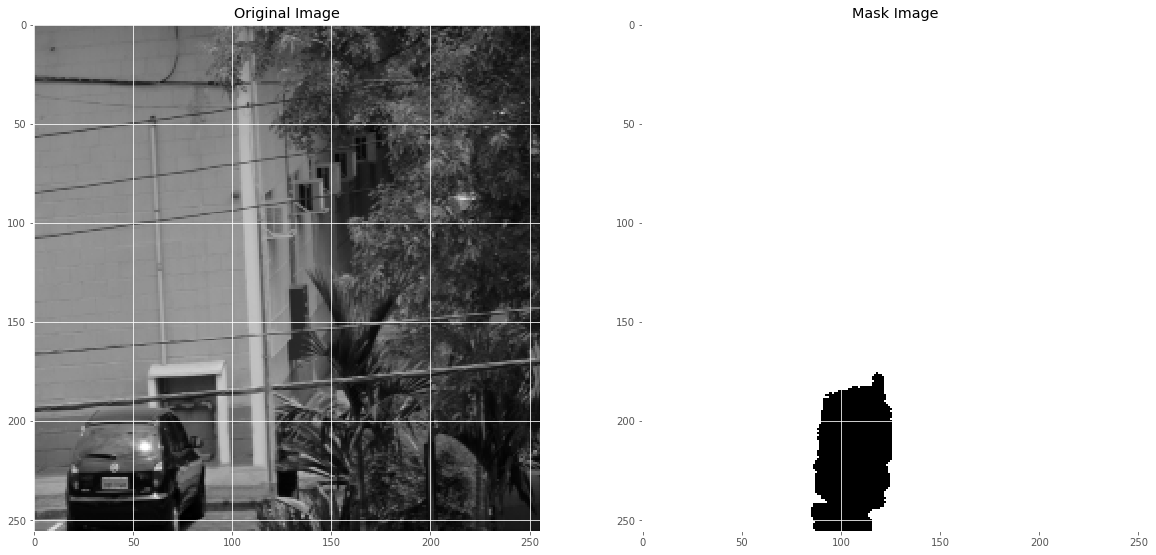

In [38]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # indication of mask

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))

ax2.imshow(X_train[ix,  0])
ax1.imshow(X_train[ix].squeeze(), cmap = 'gray')
ax1.set_title('Original Image')

if has_mask: 
    # draw a boundary(contour) in the original image separating modified part
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray')
ax2.set_title('Mask Image')

- If we notice in the image above there is a car standing in a car parking
- If we notice the second image it gives us a mask at that point where car was standing which means the image was modified by adding a car.

Text(0.5, 1.0, 'Mask Image')

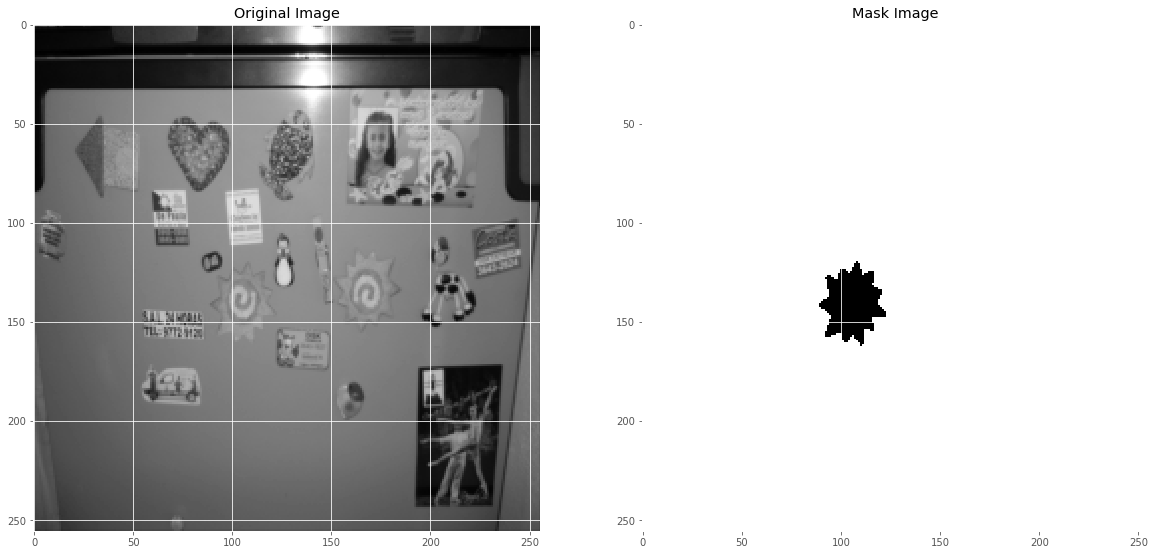

In [65]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # indication of mask

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))

ax2.imshow(X_train[ix,  0])
ax1.imshow(X_train[ix].squeeze(), cmap = 'gray')
ax1.set_title('Original Image')

if has_mask: 
    # draw a boundary(contour) in the original image separating modified part
    #ax2.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray')
ax2.set_title('Mask Image')

- In the image above we have a kindergarten board of a kid with the collection of her all craft works.
- In the second image we can see a mask located in the region where we have craft made in star shape.It means that image was modified by adding that single art piece.

Text(0.5, 1.0, 'Mask Image')

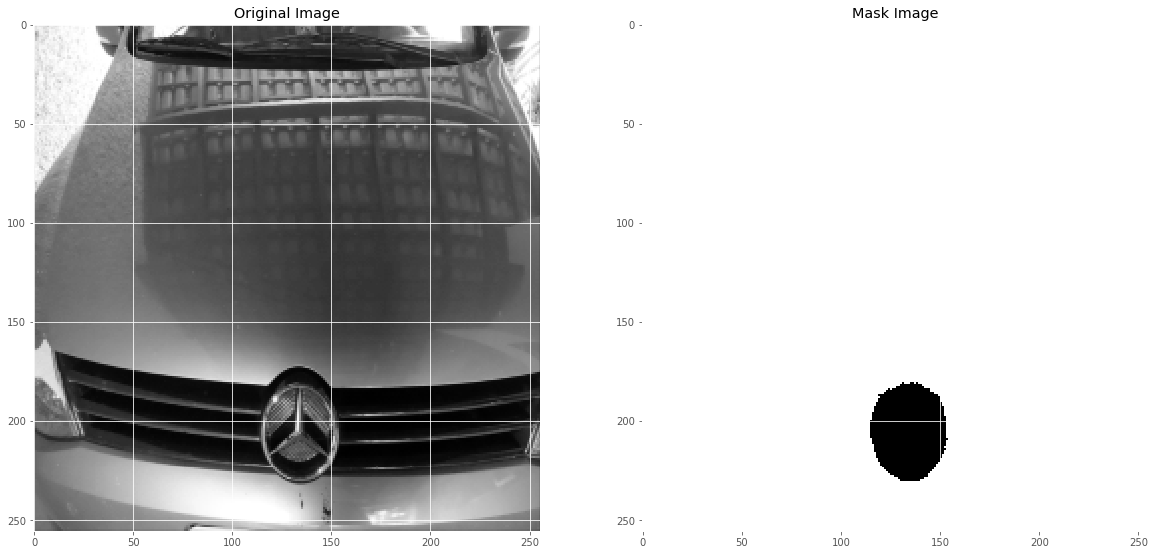

In [40]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # indication of mask

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))

ax2.imshow(X_train[ix,  0])
ax1.imshow(X_train[ix].squeeze(), cmap = 'gray')
ax1.set_title('Original Image')

if has_mask: 
    # draw a boundary(contour) in the original image separating modified part
    ax2.imshow(y_train[ix].squeeze(), cmap = 'gray')
ax2.set_title('Mask Image')

- If we check the above image we can see a single car with it's logo
- In the second image we can see a mask in the logo region which states that this image was modified in that region

## [4.0] Build a Model

In [30]:
tf.keras.backend.clear_session()

In [31]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [32]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concat([u6, c4],axis = -1)
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concat([u7, c3],axis = -1)
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concat([u8, c2], axis = -1)
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concat([u9, c1],axis = -1)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [33]:
from segmentation_models.metrics import IOUScore
metric = IOUScore()

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [34]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.3, batchnorm=True)
model.compile(optimizer= 'adam', loss="binary_crossentropy", metrics=[metric])

In [35]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [47]:
y_valid[0].shape

(256, 256, 1)

In [48]:
filepath = 'Model U-Net/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 

h=model.fit(X_train,y_train, epochs=30,callbacks=[checkpoint], verbose=2, validation_data=(X_valid,y_valid))

Train on 315 samples, validate on 135 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 69.90700, saving model to Model U-Net/model-ep001-loss1.076-val_loss69.907.h5
315/315 - 17s - loss: 1.0759 - iou_score: 0.3533 - val_loss: 69.9070 - val_iou_score: 0.2950
Epoch 2/30

Epoch 00002: val_loss did not improve from 69.90700
315/315 - 6s - loss: 0.7809 - iou_score: 0.4578 - val_loss: 224.7420 - val_iou_score: 0.0033
Epoch 3/30

Epoch 00003: val_loss improved from 69.90700 to 69.48797, saving model to Model U-Net/model-ep003-loss0.658-val_loss69.488.h5
315/315 - 6s - loss: 0.6578 - iou_score: 0.5179 - val_loss: 69.4880 - val_iou_score: 0.0227
Epoch 4/30

Epoch 00004: val_loss improved from 69.48797 to 5.02208, saving model to Model U-Net/model-ep004-loss0.609-val_loss5.022.h5
315/315 - 6s - loss: 0.6093 - iou_score: 0.5451 - val_loss: 5.0221 - val_iou_score: 0.1624
Epoch 5/30

Epoch 00005: val_loss improved from 5.02208 to 1.53680, saving model to Model U-Net/model-ep005-loss0.

## [4.1] Plotting the Learning Curve

In [49]:
h.history.keys()

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])

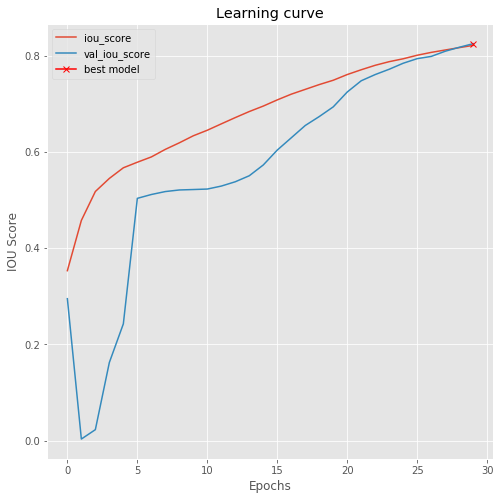

In [50]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(h.history["iou_score"], label="iou_score")
plt.plot(h.history["val_iou_score"], label="val_iou_score")
plt.plot(np.argmax(h.history["val_iou_score"]), np.max(h.history["val_iou_score"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("IOU Score")
plt.legend()

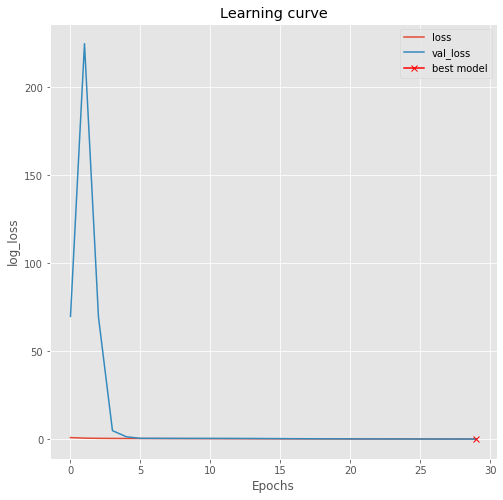

In [51]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(h.history["loss"], label="loss")
plt.plot(h.history["val_loss"], label="val_loss")
plt.plot(np.argmin(h.history["val_loss"]), np.min(h.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

## [4.2] Evaluating Model

In [52]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=2)

135/1 - 1s - loss: 0.2587 - iou_score: 0.8253


[0.26366676158375213, 0.8252527]

## [4.3] Prediction on Train and Val set

In [53]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=2)
preds_val = model.predict(X_valid, verbose=2)
#preds_test = model.predict(X_test, verbose=2)

315/1 - 2s
135/1 - 1s


In [54]:
preds_val.shape

(135, 256, 256, 1)

In [49]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 1198308, 1.0: 16299804}

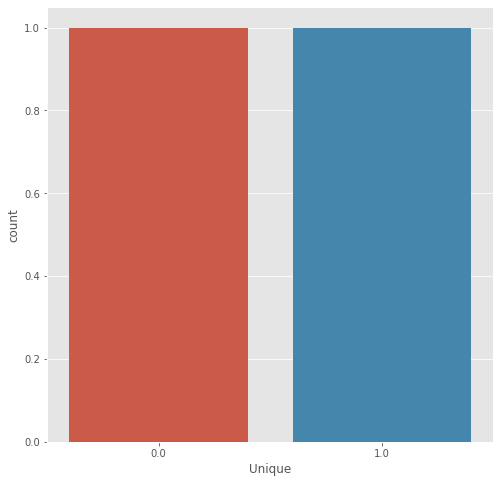

In [50]:
import seaborn as sns

df = pd.DataFrame({'Counts':counts,'Unique':unique})

plt.figure(figsize = (8,8))
sns.countplot(x = 'Unique', data = df)

In [51]:
unique, counts = np.unique(y_valid, return_counts=True)
dict(zip(unique, counts))

{0.0: 217569, 1.0: 2928159}

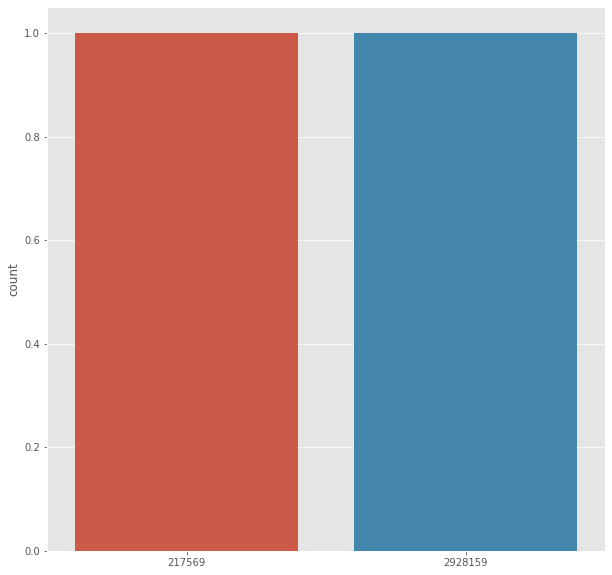

In [52]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.countplot(unique)
sns.countplot(counts)

## [4.4] Thresholding the predicted values

In [55]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [56]:
preds_tr = np.where(preds_train > 0.75,1,0)
preds_v = np.where(preds_val > 0.75,1,0)
#preds_t = np.where(preds_test > 0.75,1,0)

In [55]:
unique, counts = np.unique(preds_tr, return_counts=True)
dict(zip(unique, counts))

{0: 243161, 1: 17254951}

In [56]:
unique, counts = np.unique(preds_v, return_counts=True)
dict(zip(unique, counts))

{0: 45961, 1: 3099767}

## [5.0] Plotting the predicted,mask and binary samples

In [57]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[1].imshow(X[ix, 0])
    ax[0].imshow(X[ix].squeeze(), cmap = 'hot')
    ax[0].set_title('Original Image')
    if has_mask:
        ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask Image')


    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].imshow(preds[ix].squeeze(), cmap = 'gray')
    ax[2].set_title('Mask predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].imshow(binary_preds[ix].squeeze(), cmap = 'gray')
    ax[3].set_title('Mask Predicted binary')

## [5.1] Plotting on Train data

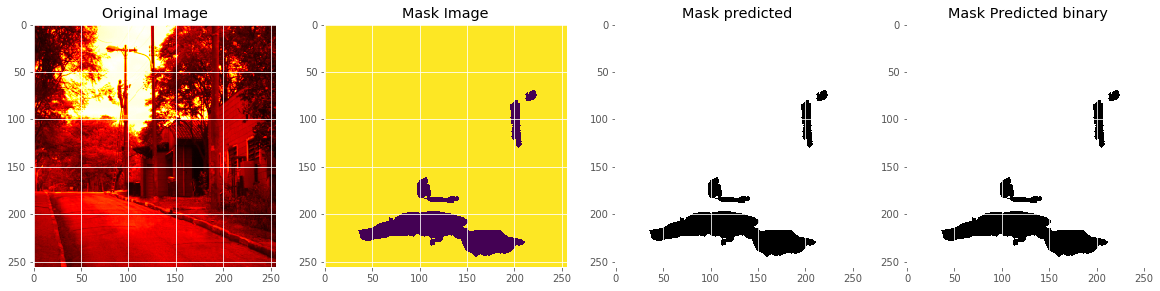

In [58]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix= 128)

## [5.3] Plotting on test data

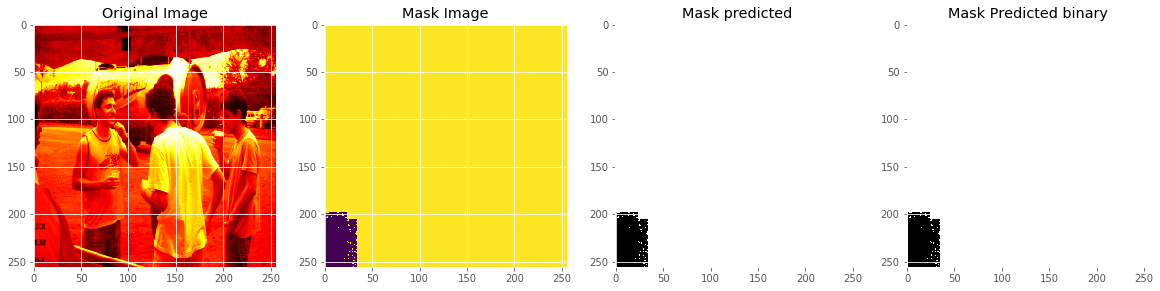

In [66]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix= 96)

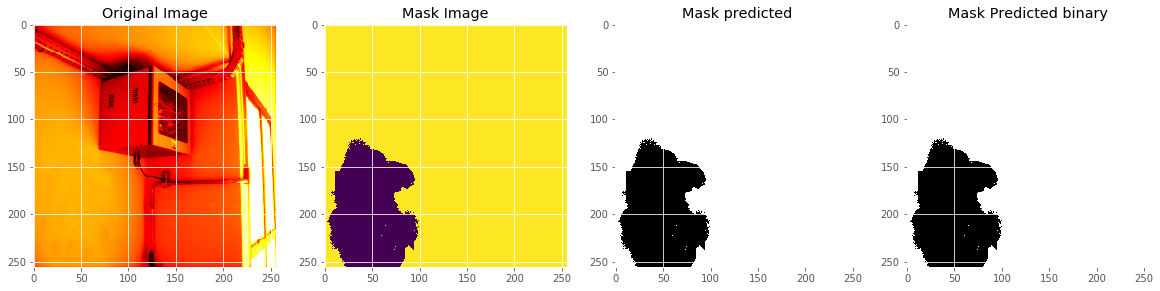

In [68]:
plot_sample(X_valid, y_valid, preds_val, preds_v, ix= 69)